In tutorial section 1, we walked through how to create and apply operations to AD instances and AD instances arrays. Based on that, we will demon how to use `boomdiff.optimize` to run gradient-based optimizers, and how to use some pre-set loss functions in `boomdiff.loss_function` to make life easier.

Our optimizers in `boomdiff.optimize` has a key advantage over optimizers in current popular pacakages like [`pytorch`](https://pytorch.org/docs/stable/optim.html): flexibility. As all the parameters are denoted by name strings, we can determine which parameters we want to update at each iteration without initializing the whole optimizer instance. This makes some mean-field assumption based algorithms, like [Coordinate descent](https://en.wikipedia.org/wiki/Coordinate_descent), much more easier to implement in `boomdiff`.

In [1]:
from boomdiff import AD, optimize, loss_function

## 2.1 Optimize with respect to scalar AD instances

Assume we want to minimize:

$$f = a^2 + b^2, \quad a,b \in \mathbb{R}$$

we know the optimization results should be $\hat{a} \approx 0, \hat{b} \approx 0, f_{min} \approx 0$

1. Initialize two variables `a` and `b`, at their staring points:

In [2]:
a = AD(-7, 'a')
b = AD(4, 'b')

2. Define the target loss function we want to minimize. 

> **loss should be a callable without arguments, this can be easily done with `lambda` syntax sugar in python**

In [3]:
loss = lambda: a**2 + b**2

In [4]:
print(f"a: {a.value()}, b: {b.value()}, loss: {loss().value()}")

a: -7, b: 4, loss: 65


3. Initialize an optimizer

At the moment, we support three optimizers: `optimize.GD`([gradient descent](https://en.wikipedia.org/wiki/Gradient_descent)), `optimize.Momentum`([momentum](https://medium.com/analytics-vidhya/momentum-a-simple-yet-efficient-optimizing-technique-ef76834e4423)), `optimize.Adam`([Adam](https://arxiv.org/pdf/1412.6980.pdf)). They share the similar APIs (for a complet API, check [here](https://github.com/team-boomeraang/cs107-FinalProject/blob/master/docs/documentation.md#optimization-methods-optimizer-subclasses)). 

I will use the Adam as an example here. 

In [5]:
opt = optimize.Adam(learning_rate=0.1, betas=(0.9, 0.999), eps=1e-08)

Need to mention here, the construction of our optimizer makes it decoupled from the parameters, which results in the flexibility.

4. Use the optimizer to update

There are two ways to update the variables: `step` will update for only one step, and `minimize` can set the step numbers you want to update. Their API are nearly the same. 

> The optimizer will update the variable

The `record` flag (determine whether you want to record the loss track) is set to `False` by default, to avoid unintended memory occupying. But we will set to `True` mannully here, to demon the loss-iteration curve at the end. 

Besides, as we mentioned above, we can freely determine the parameters we want to update without re-initialize the optimizer (This is important because you will loss the history used in history-related algorithms like Adam and Momentum, if you reinitialize the optimizer).

we can update `a` and `b` together, for one step:

In [6]:
opt.step(loss, [a,b], record=True)

In [7]:
print(f"a: {a.value()}, b: {b.value()}, loss: {loss().value()}")

a: -6.9000000000714286, b: 3.900000000125, loss: 62.820000001960715


or we can update `a` only for one step:

In [8]:
opt.step(loss, [a], record=True)

In [9]:
print(f"a: {a.value()}, b: {b.value()}, loss: {loss().value()}")

a: -6.765669988048683, b: 3.900000000125, loss: 60.98429038815767


or update `b` only for one step: 

In [10]:
opt.step(loss, [b], record=True)

In [11]:
print(f"a: {a.value()}, b: {b.value()}, loss: {loss().value()}")

a: -6.765669988048683, b: 3.7657155487753675, loss: 59.95490398147123


or update `a` and `b` for 500 steps with `minimize`

In [12]:
opt.minimize(loss, [a,b], steps=500, record=True)

In [13]:
print(f"a: {a.value()}, b: {b.value()}, loss: {loss().value()}")

a: -9.181156714018847e-12, b: 9.537149048472307e-13, loss: 8.520321072710111e-23


Apparently, the results are close to our expectation. We can draw the loss-iteration curve by:

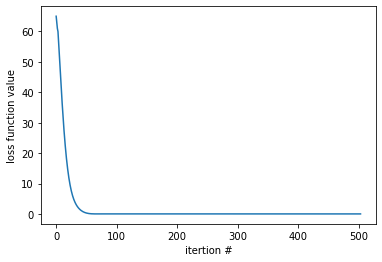

In [14]:
opt.plot_loss_func() #This only works when you set record=True in all previous updates 

## 2.2 Optimize with respect to AD instances arrays

The idea and procedure is similar. Let's say we are going to minimize the Frobinius norm of a 3*3 matrix W:

$$\min F_n = \sum_{ij}W_{ij}^2$$

In [15]:
import numpy as np
np.random.seed(14)

In [16]:
W = AD.from_array(np.random.randint(-10,10, size=(3,3)), prefix="W")

In [17]:
loss = lambda: AD.sum(W**2)

In [18]:
print("Initial W:")
print(AD.to_array(W).round(3))
print("Initial loss: ", loss().round(3).value())

Initial W:
[[ 1.  2. -3.]
 [-4.  0.  0.]
 [ 6. -2.  3.]]
Initial loss:  79


In [19]:
opt_arr = optimize.Adam(learning_rate=0.1)

Then we call the `step` or `minimize` to update. `var_list` arguments only need to be 1D list or array of parameters, no order required. Because the parameters are denoted by unique name string. You can even concatenate different list of parameters as `var_list`, as long as all parameters appear in the `loss` function.

In [20]:
opt_arr.minimize(loss, W.reshape(-1), steps=500, record=True)

In [21]:
print("Optimized W:")
print(AD.to_array(W).round(3))
print("Final loss: ", loss().round(3).value())

Optimized W:
[[ 0. -0.  0.]
 [ 0.  0.  0.]
 [ 0.  0. -0.]]
Final loss:  0.0


Show the loss-iteration curve

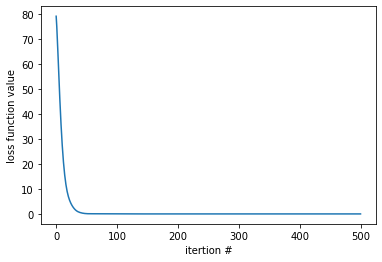

In [22]:
opt_arr.plot_loss_func()

## 2.3 Pre-set loss functions

As we can see above, user can define customized loss functions to optimize with `boomdiff`, which enabled broader user cases. For convinience and educational purpose, in particular, we have included the API for two common loss functions: mean squared error in the context of a linear model (`loss_functions.linear_mse()`) and binary cross-entropy for a logistic model (`loss_functions.logistic_cross_entropy`). Importantly, these two loss functions make fairly strong assumptions regarding the functional form of the data. Thus, we have titled the functions to inform the user of their purpose. 

### (1) `linear_mse` loss functions

As a review of mean squared error, the loss function takes the form:

$$\sum_{i=1}^n (y_i - \hat{y_i})^2$$

for some observed outcome, $y_i$ and prediction of an arbitrary model, $\hat{y_i}$. In this case, we will restrict the functional form of the model to be linear, as is the case of linear regression (and hence the name linear_mse()). That is, we assume:

$$y_i = \beta_1 x_1 + ... + \beta_p x_p + \epsilon_i$$

where $\epsilon_i$ is assumed to be Gaussian noise. Please also note that we will not be estimating an intercept in this case. For that to be included, the row of value 1 will be needed to be added to the design matrix for use in this function. With this in mind, our loss function takes the form:

$$f(\beta_1, ... \beta_p) = \sum_{i=1}^n (y_i - (\beta_1x_1 + ... + \beta_p x_p))^2$$.

### (2) `logistic_cross_entropy` loss functions

This loss function is featured in logistic binary regression models: we have $N$ observed data $X^k$ with $M$ different features, each observation has a binary classification label $y^k$. We would like to find a set of feature weights $\beta$ and a bias $b$, to minimize the cross entropy loss, the second equation: 

$$\hat{y}^k = \text{logistic}(b+\beta_0X_0^k + \beta_1X_1^k + \dots + \beta_{M-1}X_{M-1}^k)$$

$$\text{arg min}_{\beta,b}[- \frac{1}{N}\sum_{k=1}^N(y^k\log(\hat{y}^k) + (1-y^k)\log (1- \hat{y}^k))]$$

We will demonstrate the two kinds of loss functions in tutorial section 3 and section 4, by examples.